# Social Media Processing

This notebook shows how to use HuggingFace's package to import and train regression models to assess humor rating in social media posts in English (SemEval2021: HaHackathon: Detecting and Rating Humor and Offense https://competitions.codalab.org/competitions/27446, **Task-1b**).

Detection of humour, especially in social media posts, poses a linguistic challenge to NLP, due to the noise, figurative language, contextuality and subjectivity. You will hence try different methods to address those challenges such as preprocessing, data augmentation, ensembling and multi-task learning.

We will download and unzip the data from here: http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip.


We recommend you to do this lab on a Colab GPU provided by Google.

In [7]:
!wget http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
!unzip '/content/hahackathon_data.zip' -x __MACOSX/*

--2025-03-17 03:32:36--  http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
Resolving smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)... 129.215.10.97
Connecting to smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)|129.215.10.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571603 (558K) [application/zip]
Saving to: ‘hahackathon_data.zip’

hahackathon_data.zi 100%[===================>] 558.21K   810KB/s    in 0.7s    

2025-03-17 03:32:37 (810 KB/s) - ‘hahackathon_data.zip’ saved [571603/571603]

Archive:  /content/hahackathon_data.zip
   creating: hahackathon data/
  inflating: hahackathon data/.DS_Store  
  inflating: hahackathon data/test.csv  
  inflating: hahackathon data/dev.csv  
  inflating: hahackathon data/train.csv  


First, we need to install Hugging Face [transformers](https://huggingface.co/transformers/index.html) and [Sentence piece Tokenizers](https://github.com/google/sentencepiece), as well as some helper libraries, with the following commands.

In [8]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q  ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.utils.data import Dataset, DataLoader

We define the fix seed method to be able to introduce variety into ensembling models.

In [10]:
# Set random seed for reproducibility
def set_random_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_random_seed()

## Regression with BERT

We will use the [DistilBert](https://arxiv.org/abs/1910.01108v4) model and its Tokeniser following the preprocessing code from Lab on Aspect-Based Sentiment Analysis.

In [11]:
import tqdm

# Constants
PAD_LENGTH = 128
BATCH_SIZE = 256
EPOCHS = 5
bert_model = 'distilbert-base-uncased'

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert_model, do_lower_case=True, max_length=PAD_LENGTH, padding='max_length', truncation=True)

def tokenize(sentences, tokenizer, pad_length=PAD_LENGTH, pad_to_max_length=True):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        return inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids']

    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])
    return input_ids, input_masks, input_segments


Let's read the data using Pandas.

In [12]:
import pandas as pd

# Load data with only the necessary columns
train_df = pd.read_csv('hahackathon data/train.csv', usecols = ['text','humor_rating','offense_rating'])
dev_df = pd.read_csv('hahackathon data/dev.csv', usecols = ['text','humor_rating','offense_rating'])
test_df = pd.read_csv('hahackathon data/test.csv', usecols = ['text','humor_rating','offense_rating'])

# Drop the Nans
train_df = train_df.dropna()
dev_df = dev_df.dropna()
test_df = test_df.dropna()

Let's check a couple of examples.

In [13]:
train_df

,text,humor_rating,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,2.42,0.20
1,A man inserted an advertisement in the classif...,2.50,1.10
2,How many men does it take to open a can of bee...,1.95,2.40
3,Told my mom I hit 1200 Twitter followers. She ...,2.11,0.00
4,Roses are dead. Love is fake. Weddings are bas...,2.78,0.10
...,...,...,...
7991,"Sins are like viruses, it's better you keep th...",2.13,0.10
7993,My daughter wanted a Cinderella themed birthda...,3.70,0.00
7996,Why are aspirins white? Because they work sorry,1.33,3.85
7997,"Today, we Americans celebrate our independence...",2.55,0.00


In [14]:
# Get the post text
train_examples_list = train_df['text'].tolist()
dev_examples_list = dev_df['text'].tolist()
test_examples_list = test_df['text'].tolist()

# Get the humour rating for the regression task (we normalise, the values are between 0 and 5)
train_targets_list = (train_df['humor_rating']/5).tolist()
dev_targets_list = (dev_df['humor_rating']/5).tolist()
test_targets_list = (test_df['humor_rating']/5).tolist()

In [15]:
def get_bert_inputs(examples_list, targets):
  input_ids=list()
  attention_masks=list()

  bert_inp=tokenize(examples_list, tokenizer)
  input_ids = bert_inp[0]
  attention_masks = bert_inp[1]

  return input_ids, attention_masks, targets

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
dev_input_ids, dev_attention_masks, dev_targets = get_bert_inputs(dev_examples_list, dev_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**Task 1: Build a neural bag of words model using DistilBERT embeddings and the sigmoid activation on the output layer for the regression task.**

Investigate its performance using the Mean Squared Error (MSE) metric. We will use this metric as the loss function as well. We will also use the Adam optimiser with `learning_rate=2e-5`. This code is already provided.

*Hint*: You can reuse the code from Lab on Aspect-Based Sentiment Analysis (Model 2).

In [16]:
class GlobalAveragePooling1DMasked(nn.Module):
    def forward(self, x, mask):
        mask = mask.unsqueeze(-1).float()
        x = x * mask
        sum_x = torch.sum(x, dim=1)
        sum_mask = torch.sum(mask, dim=1)
        return sum_x / sum_mask

# Define model
class BERTRegressionModel(nn.Module):

    def __init__(self, pad_length=128):
        super(BERTRegressionModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model)
        self.global_avg_pool = GlobalAveragePooling1DMasked()
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, 16)
        self.activation = nn.Sigmoid()
        self.output_reg = nn.Linear(16, 1)

    def forward(self, input_ids, attention_mask):
        """
        Task 1

        Begin
        """
        #extract BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        #global average pooling
        pooled_output = self.global_avg_pool(last_hidden_state, attention_mask)
        #transform hidden layer
        hidden_output = self.hidden_layer(pooled_output)
        #sigmoid activation
        activated_output = self.activation(hidden_output)
        #regression output of shape (batch size, 1)
        out_reg = self.output_reg(activated_output)
        """
        End Task 1
        """

        return out_reg


model = BERTRegressionModel()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [17]:
print(model)

BERTRegressionModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [18]:
# Dataset Class
class HumorDataset(Dataset):
    def __init__(self, input_ids, attention_masks, targets):
        self.input_ids = torch.tensor(input_ids)
        self.attention_masks = torch.tensor(attention_masks)
        self.targets = torch.tensor(targets)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'target': self.targets[idx].float()
        }

In [19]:
# Training setup
def train_model(model, train_loader, val_loader, device, epochs=EPOCHS, lr=2e-5):
    model.train()
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)
            outputs = model(input_ids, attention_mask)

            loss = loss_fn(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['target'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs.squeeze(), targets)
                val_loss += loss.item()

        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")


We evaluate our model on the test set.

In [20]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets)
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Instantiate model and train
model = BERTRegressionModel()
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


Train Loss: 0.1714, Val Loss: 0.0135


Epoch 2/5: 100%|██████████| 20/20 [00:46<00:00,  2.30s/it]


Train Loss: 0.0131, Val Loss: 0.0130


Epoch 3/5: 100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Train Loss: 0.0120, Val Loss: 0.0121


Epoch 4/5: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Train Loss: 0.0114, Val Loss: 0.0118


Epoch 5/5: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.0112, Val Loss: 0.0115


In [22]:
from sklearn.metrics import mean_squared_error


# Evaluate the model
def evaluate_model(model, test_loader, device, multi_task=False):
    model.eval()
    model.to(device)
    loss_fn = nn.MSELoss()

    preds = []
    gt = []
    loss_list = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)
            outputs = model(input_ids, attention_mask)
            #for multi_task setting we only evaluate the humor rating to make it inline with the other models.
            if multi_task:
              outputs = outputs[:,0]
              targets = targets[:,0].squeeze()
            preds.append(outputs.squeeze().cpu().numpy())
            gt.append(targets.cpu().numpy())
            loss_list.append(loss_fn(outputs.squeeze(), targets).cpu().numpy())

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)

    mse = mean_squared_error(gt, preds)
    avg_loss = np.mean(loss_list)
    print(f'Test loss: {avg_loss:.4f}')
    print(f'Test Mean Squared Error: {mse:.4f}')
    return preds, gt

preds, test_targets = evaluate_model(model, test_loader, device)

Test loss: 0.0116
Test Mean Squared Error: 0.0119


Get the array of predictions here so that you can plot the outputs later.

## Predictive Distribution

We compute min, max and mean for the golden and predicted humour ratings.

In [23]:
min(preds), max(preds), preds.mean()

(0.35658523, 0.5482287, 0.45032236)

In [24]:
min(test_targets), max(test_targets), test_targets.mean()

(0.054, 0.684, 0.42383412)

<Axes: >

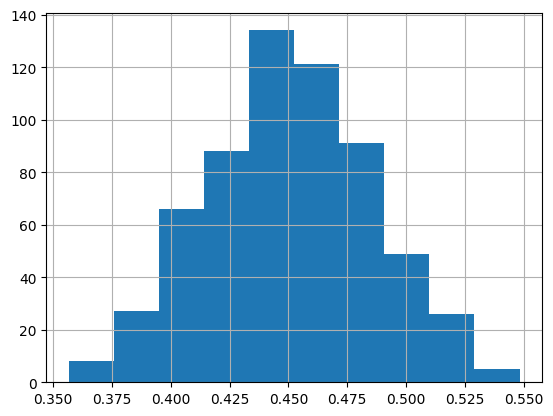

In [25]:
pd.Series(preds).hist()

<Axes: >

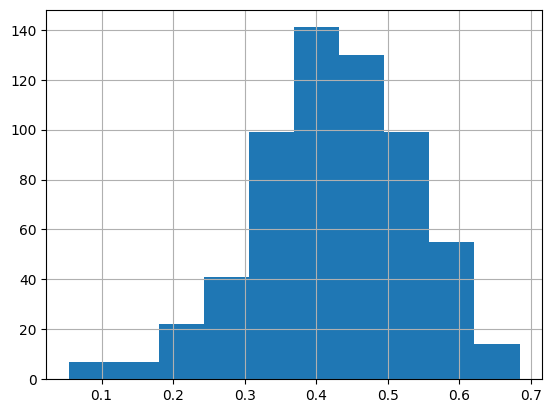

In [26]:
pd.Series(test_targets).hist()

Next, we plot the true vs predicted humour grade for our model.

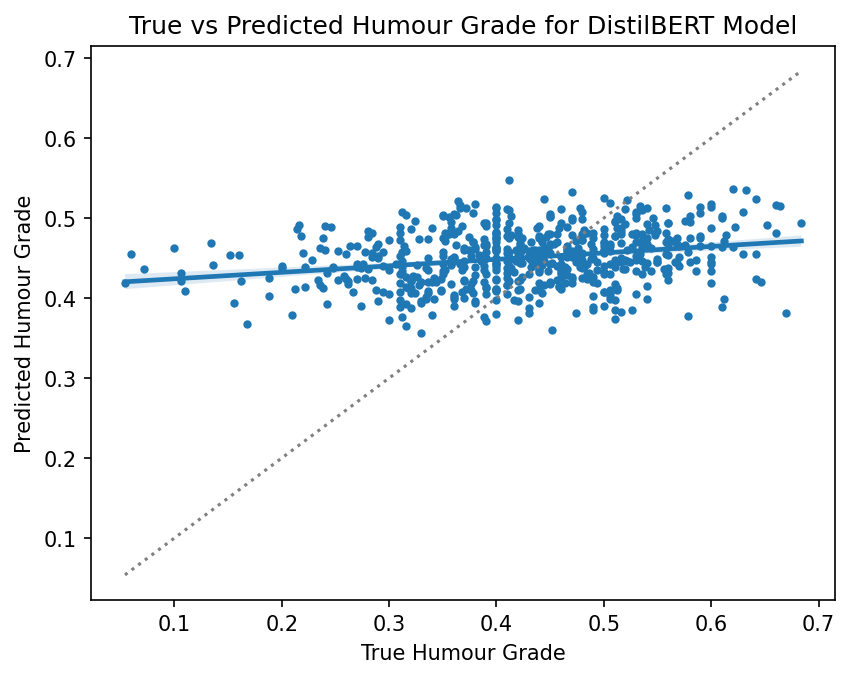

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
def get_pred_true_plot(preds, labels, title):
    limits = [labels.min(), labels.max()]
    fig, ax = plt.subplots()
    fig.set_dpi(150)
    ax.set_title(title)
    ax.scatter(labels, preds, marker='.')
    ax.plot(limits, limits, color="gray", linestyle=":")
    ax.set_xlabel('True Humour Grade')
    ax.set_ylabel('Predicted Humour Grade')
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={"s": 5})
    plt.show()

get_pred_true_plot(preds, test_targets, 'True vs Predicted Humour Grade for DistilBERT Model')

Our regressor tends to smooth down the extreme rating values to make them closer to the mean.

# Feature Engineering & Data Augmentation

**Task 2: Preprocess the textual data with the Ekphrasis library following the standard pipeline https://github.com/cbaziotis/ekphrasis#text-pre-processing-pipeline. How does this affect the performance?**

*Hint*: You might not want to annotate terms in order to keep the same length of the input sentences (for this, do not use the parameter `annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'}`).

In [28]:
!pip install -q ekphrasis
!pip3 install -q emoji==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [29]:
"""
Task 2

Begin
"""
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

#initializing the text preprocessor (without annotation)
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

"""
End Task 2
"""
new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
new_dev_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in dev_examples_list]
new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]


/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [30]:
print("Original Text:", train_examples_list[0])
print("Preprocessed Text:", new_train_examples_list[0])

Original Text: TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit...
Preprocessed Text: tennessee : we are the best state . nobody even comes close . * elevennessee walks into the room * tennessee : oh shit . . .


In [31]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(new_train_examples_list, train_targets_list)
dev_input_ids, dev_attention_masks, dev_targets = get_bert_inputs(new_dev_examples_list, dev_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(new_test_examples_list, test_targets_list)


# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets)
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = BERTRegressionModel()
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Train Loss: 0.0494, Val Loss: 0.0186


Epoch 2/5: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Train Loss: 0.0144, Val Loss: 0.0124


Epoch 3/5: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.0119, Val Loss: 0.0120


Epoch 4/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0114, Val Loss: 0.0116


Epoch 5/5: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.0110, Val Loss: 0.0114


In [32]:
preds, test_targets = evaluate_model(model, test_loader, device)

Test loss: 0.0121
Test Mean Squared Error: 0.0124


In [34]:
min(preds), max(preds), preds.mean()

(0.36339033, 0.54666567, 0.45857787)

In [35]:
min(test_targets), max(test_targets), test_targets.mean()

(0.054, 0.684, 0.42383412)

Your results may be different depending on the implementation but typically special preprocessing does not drastically change the performance for this task.

**Task 3: Augment the training data twice by changing the original data via two methods from the Nlpaug (https://github.com/makcedward/nlpaug) library: (a) synonym replacement from WordNet; (b) deletion of random words. Comment on which method gives the best performance.**

*Hint*: Use the Synonym Augmenter and Random Word Augmenter (Delete word randomly) classes as follows:
```
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)

aug = naw.RandomWordAug()
augmented_text = aug.augment(text)
```





For more examples check https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

In [36]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 12.4 MB/s eta 0:00:00


In [43]:
# Get the data again to apply augmentation
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

In [44]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger_eng')

"""
Task 3

Begin
"""
augmented_texts_synonym = []
augmented_texts_random_del = []
augmented_targets = []
#replacing synonyms
synonym_aug = naw.SynonymAug(aug_src='wordnet')

#random word deletion
random_del_aug = naw.RandomWordAug()

for text, target in zip(train_examples_list, train_targets_list):
    #generate augmented versions
    augmented_texts_synonym.append(synonym_aug.augment(text))

    augmented_texts_random_del.append(random_del_aug.augment(text))

    # Duplicate targets for the new samples
    augmented_targets.append(target)

#original + augmented
final_synonym_train_examples = train_examples_list + augmented_texts_synonym
final_random_del_train_examples = train_examples_list + augmented_texts_random_del
final_train_targets = train_targets_list + augmented_targets



"""
End Task 3
"""


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


'\nEnd Task 3\n'

In [40]:
print(train_examples_list[-2])
print(train_examples_list[4930])

Today, we Americans celebrate our independence from Britain while planning our escape to Canada.
Today, we Americans celebrate our independence from Britain while planning our escape to Canada.


In [45]:
#synonym
train_examples_list = final_synonym_train_examples
train_targets_list = final_train_targets
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
dev_input_ids, dev_attention_masks, dev_targets = get_bert_inputs(dev_examples_list, dev_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)

# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets)
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


We have now augmented the original data twice:

In [46]:
print("Training examples before augmentation:")
print(len(train_df['text'].tolist()))
print("Training examples after augmentation:")
print(len(train_examples_list))

Training examples before augmentation:
4932
Training examples after augmentation:
9864


In [47]:
model = BERTRegressionModel()
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 39/39 [01:36<00:00,  2.48s/it]


Train Loss: 0.1186, Val Loss: 0.0130


Epoch 2/5: 100%|██████████| 39/39 [01:35<00:00,  2.46s/it]


Train Loss: 0.0129, Val Loss: 0.0126


Epoch 3/5: 100%|██████████| 39/39 [01:35<00:00,  2.45s/it]


Train Loss: 0.0127, Val Loss: 0.0122


Epoch 4/5: 100%|██████████| 39/39 [01:35<00:00,  2.45s/it]


Train Loss: 0.0124, Val Loss: 0.0118


Epoch 5/5: 100%|██████████| 39/39 [01:35<00:00,  2.45s/it]


Train Loss: 0.0121, Val Loss: 0.0116


In [48]:
preds, test_targets = evaluate_model(model, test_loader, device)

Test loss: 0.0122
Test Mean Squared Error: 0.0125


In [49]:
#deletion
train_examples_list = final_random_del_train_examples
train_targets_list = final_train_targets
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
dev_input_ids, dev_attention_masks, dev_targets = get_bert_inputs(dev_examples_list, dev_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)

# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets)
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("Training examples before augmentation:")
print(len(train_df['text'].tolist()))
print("Training examples after augmentation:")
print(len(train_examples_list))



/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training examples before augmentation:
4932
Training examples after augmentation:
9864


In [50]:
model = BERTRegressionModel()
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 39/39 [01:36<00:00,  2.46s/it]


Train Loss: 0.0222, Val Loss: 0.0127


Epoch 2/5: 100%|██████████| 39/39 [01:35<00:00,  2.46s/it]


Train Loss: 0.0124, Val Loss: 0.0117


Epoch 3/5: 100%|██████████| 39/39 [01:35<00:00,  2.45s/it]


Train Loss: 0.0121, Val Loss: 0.0115


Epoch 4/5: 100%|██████████| 39/39 [01:35<00:00,  2.46s/it]


Train Loss: 0.0118, Val Loss: 0.0112


Epoch 5/5: 100%|██████████| 39/39 [01:35<00:00,  2.46s/it]


Train Loss: 0.0116, Val Loss: 0.0110


In [51]:
preds, test_targets = evaluate_model(model, test_loader, device)

Test loss: 0.0115
Test Mean Squared Error: 0.0118


Your results may be different depending on the implementation but typically there are no drastic differences between the augmentation setups.

# Ensembled BERT Model

In this section you will train and evaluate an **ensemble** of BERT models.

We define the hyperparameters, including the number of models we want to ensemble (RERUNS=3, i.e., 3 models).

**Task 4: Train three DistilBERT models, get their predictions on the test set, take the mean of those predictions and evaluate this ensembled prediction. Comment on the resulting performance.**

We create three models in a loop, set a new random seed before creating each of them (`set_random_seed(seed=random.randint(0, 500))`) and accumulate predictions per model in a list.

In [52]:
# Get the train data again to avoid any confusion
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

# Prepare DataLoader
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [53]:
RERUNS = 3
# We may save each model to a list
# trained_models = list()
# We save the predictions of each model to the list
all_model_preds = list()


for i in range(RERUNS):

    set_random_seed(seed=random.randint(0, 500))

    """
    Task 4

    Begin
    """
    model = BERTRegressionModel().to(device)

    #train the model
    train_model(model, train_loader, dev_loader, device)

    # evaluate on test set and store predictions
    preds, _ = evaluate_model(model, test_loader, device)
    all_model_preds.append(preds)

# Convert list to numpy array for easy averaging
all_model_preds = np.array(all_model_preds)  # Shape: (3, num_samples)

# Compute the mean prediction across all models
ensemble_preds = np.mean(all_model_preds, axis=0)

# Evaluate ensemble performance
test_targets = np.array(test_targets)  # Ensure test targets are in correct format
ensemble_mse = mean_squared_error(test_targets, ensemble_preds)



"""
  End Task 4
"""



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Train Loss: 0.0324, Val Loss: 0.0140


Epoch 2/5: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.0124, Val Loss: 0.0122


Epoch 3/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0115, Val Loss: 0.0118


Epoch 4/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0111, Val Loss: 0.0116


Epoch 5/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0107, Val Loss: 0.0114
Test loss: 0.0124
Test Mean Squared Error: 0.0127


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.0165, Val Loss: 0.0125


Epoch 2/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0122, Val Loss: 0.0118


Epoch 3/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0115, Val Loss: 0.0115


Epoch 4/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0111, Val Loss: 0.0111


Epoch 5/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0105, Val Loss: 0.0108
Test loss: 0.0115
Test Mean Squared Error: 0.0118


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0477, Val Loss: 0.0191


Epoch 2/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0138, Val Loss: 0.0123


Epoch 3/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0116, Val Loss: 0.0118


Epoch 4/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0111, Val Loss: 0.0116


Epoch 5/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0110, Val Loss: 0.0113
Test loss: 0.0123
Test Mean Squared Error: 0.0126


'\n  End Task 4\n'

In [54]:
from sklearn.metrics import classification_report, mean_squared_error

mean_preds = np.mean(np.array(all_model_preds), axis=0)
ensemble_mse = mean_squared_error(test_targets, mean_preds)

print('Ensemble Test MSE : {:.4f}'.format(ensemble_mse))

Ensemble Test MSE : 0.0122


Your results may be different depending on the implementation but typically ensembling slightly improves the performance for this task.

# Multi-task Learning with BERT

**Task 5: Train a multi-task (MTL) model with the additional regression task of predicting the offense rating. The code to fetch these data is provided below. Comment on the resulting performance for the two models (single-task from task 1 and MTL).**

*Hint*: The MTL model will have two identical output layers (one for predicting humour rating, the other to predict offense rating). The layers need to be concatenated before applying the loss fuctions.

In [55]:
import gc
if 'model' in locals():
  del model
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [56]:
set_random_seed()

class BertMultitaskModel(nn.Module):
    """
    Task 5

    Begin
    """
    def __init__(self, pad_length=128):
        super(BertMultitaskModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.global_avg_pool = GlobalAveragePooling1DMasked()

        #shared hidden layer
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, 16)
        self.activation = nn.Sigmoid()

        # two output layers: one for humor and one for offense
        self.output_humor = nn.Linear(16, 1)
        self.output_offense = nn.Linear(16, 1)


    def forward(self, input_ids, attention_mask):
        #extract BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        #global average pooling
        pooled_output = self.global_avg_pool(last_hidden_state, attention_mask)

        #shared hidden layer
        hidden_output = self.hidden_layer(pooled_output)
        activated_output = self.activation(hidden_output)

        #outputs for humor and offense ratings
        out_reg1 = self.output_humor(activated_output)
        out_reg2 = self.output_offense(activated_output)

        #concatenate outputs
        return torch.cat([out_reg1, out_reg2], dim=1)
    """
    End Task 5
    """

In [57]:
model = BertMultitaskModel(pad_length=PAD_LENGTH).to(device)


In [58]:
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

# Get the offense ratings for the second regression task (we normalise them as well)
train_targets2_list = (train_df['offense_rating']/5).tolist()
dev_targets2_list = (dev_df['offense_rating']/5).tolist()
test_targets2_list = (test_df['offense_rating']/5).tolist()

train_targets2 = np.array(train_targets2_list)
dev_targets2 = np.array(dev_targets2_list)
test_targets2 = np.array(test_targets2_list)

# Prepare DataLoader
train_targets_mix = [[i[0],i[1]] for i in zip(train_targets,train_targets2)]
train_dataset = HumorDataset(train_input_ids, train_attention_masks, train_targets_mix)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_targets_mix = [[i[0],i[1]] for i in zip(dev_targets,dev_targets2)]
dev_dataset = HumorDataset(dev_input_ids, dev_attention_masks, dev_targets_mix)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_targets_mix = [[i[0],i[1]] for i in zip(test_targets,test_targets2)]
test_dataset = HumorDataset(test_input_ids, test_attention_masks, test_targets_mix)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [59]:
# Instantiate model and train
train_model(model, train_loader, dev_loader, device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Train Loss: 0.0488, Val Loss: 0.0454


Epoch 2/5: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Train Loss: 0.0303, Val Loss: 0.0370


Epoch 3/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0250, Val Loss: 0.0282


Epoch 4/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0191, Val Loss: 0.0217


Epoch 5/5: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Train Loss: 0.0160, Val Loss: 0.0201


In [60]:
preds, test_targets = evaluate_model(model, test_loader, device, multi_task=True)

Test loss: 0.0130
Test Mean Squared Error: 0.0133


Your results may be different depending on the implementation but typically MTL slightly improves the performance over the single-task model trained in similar conditions.